In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ProjectFakeNews/processed_fake_news.csv') # load the prepocessed dataset

In [4]:
df.head()

,Unnamed: 0,text,label,lemm_sent,rephrased,joined_lemm
0,0,No comment is expected from Barack Obama Membe...,1,"['comment', 'expect', 'barack', 'obama', 'memb...","['comment', 'expect', 'barack_obama', 'member'...",comment expect barack_obama member fyf911 fuky...
1,1,Did they post their votes for Hillary already?,1,"['post', 'vote', 'hillary']","['post', 'vote_hillary']",post vote_hillary
2,2,"Now, most of the demonstrators gathered last ...",1,"['demonstrator', 'gather', 'night', 'exercise'...","['demonstrator_gather', 'night', 'exercise_con...",demonstrator_gather night exercise_constitutio...
3,3,A dozen politically active pastors came here f...,0,"['dozen', 'politically', 'active', 'pastor', '...","['dozen', 'politically_active', 'pastor', 'com...",dozen politically_active pastor come private_d...
4,4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"['rs-28', 'sarmat', 'missile', 'dub', 'satan',...","['rs-28_sarmat', 'missile_dub', 'satan_2', 're...",rs-28_sarmat missile_dub satan_2 replace_ss-18...


In [5]:
df['joined_lemm'] = df.joined_lemm.apply(lambda x: str(x))

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# tokenize joined_lemm column and prepare the data to train our word2vec model
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["joined_lemm"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [8]:
from gensim.models import Word2Vec 

In [9]:
# initialize our word2vec model
model_w2v = Word2Vec(
            X,
            vector_size=300, # desired no. of features/independent variables
            window=5, # context window size                                
            workers= -1, # no.of cores
) 

#train our word2vec model
model_w2v.train(X, total_examples= len(df['joined_lemm']), epochs=10)

(0, 0)

In [10]:
# vocabulary length
len(model_w2v.wv)

265789

In [11]:
# similar words
model_w2v.wv.most_similar("trump")

[('dollar_amount', 0.26124975085258484),
 ('agonize', 0.24679452180862427),
 ('torah', 0.24466831982135773),
 ('galloway', 0.2388921082019806),
 ('barrel_day', 0.23860499262809753),
 ('repeatedly_question', 0.23729759454727173),
 ('force_baltic', 0.23728638887405396),
 ('entire_book', 0.23591195046901703),
 ('fighting_chance', 0.23577436804771423),
 ('deliberative_process', 0.2350725382566452)]

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [13]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

In [14]:
texts = df['joined_lemm']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 72134 texts.


In [15]:
# tokenizing sentences into words 
tokenizer = Tokenizer()
# using fit_on_texts method assigning values to particular words
tokenizer.fit_on_texts(texts)
# texts_to_sequences method is used to give particular integer values to word
sequences = tokenizer.texts_to_sequences(texts)

# calculating word_index
word_index = tokenizer.word_index
# padding data to the same length for each samples
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='post', 
                     truncating='post')
print(len(word_index))
print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

233928
Found 233928 unique tokens.
Shape of data tensor: (72134, 1000)
Shape of label tensor: (72134,)


In [16]:
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break  

say -> 1
s -> 2
trump -> 3
president -> 4
people -> 5
year -> 6
state -> 7
clinton -> 8
mr -> 9
u -> 10


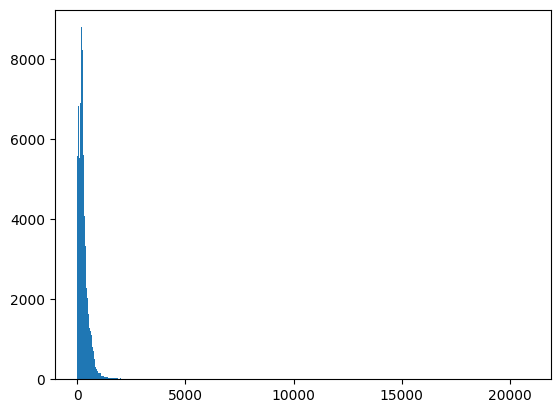

In [17]:
# plot the distibution of the sentence length
plt.hist([len(x) for x in sequences], bins=500)
plt.show()

In [18]:
vocab_size = len(tokenizer.word_index) + 1 # vocabulary size

In [19]:
vocab_size

233929

In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # initialize the embedding matrix

In [21]:
# create an embedding matrix from the word2vec model to pass to the embedding layer as weights
for word, i in word_index.items():
    try:
        embedding_vector = model_w2v.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM) # if word is not found random numbers are assigned.

In [22]:
from sklearn.model_selection import train_test_split

# test,train and validation split.

x, x_test, y, y_test = train_test_split(data, 
                                        labels, 
                                        test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x,
                                                  y, 
                                                  test_size=0.1)

print('train size:',x_train.shape[0])
print('test size:', x_test.shape[0])

train size: 51936
test size: 14427


In [23]:
from keras import layers
from keras.models import Sequential

In [24]:
dropout = 0.4
model = Sequential()

# defining embedding layer where embedding dimension/ vector size is defined as 300 and input length is set as 1000. 
model.add(layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# defining a convolution layer, number of filters are set as 128 and kernal size is defined as 1 X 5.
model.add(layers.Conv1D(128,5, activation='ReLU'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(layers.MaxPool1D(2))
# adding a dropout of 0.4
model.add(layers.Dropout(dropout))
# defining a convolution layer, number of filters are set as 64 and kernal size is defined as 1 X 3.
model.add(layers.Conv1D(64,3, activation='ReLU'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(layers.MaxPooling1D(2, strides= 2))
# adding a dropout of 0.4
model.add(layers.Dropout(dropout))
# defining an LSTM layer with 64 units
model.add(layers.LSTM(64,return_sequences=True))
# defining an LSTM layer with 32 units
model.add(layers.LSTM(32,return_sequences=True))
#Flatten layer
model.add(layers.Flatten())

# dense layer with 64 neurons and ReLu activation function
model.add(layers.Dense(64, activation='ReLU'))
model.add(layers.Dropout(dropout))
# dense layer with 64 neurons and ReLu activation function
model.add(layers.Dense(16, activation='ReLU'))
model.add(layers.Dropout(dropout))
# output layer with 1 neurons and sigmoid activation function for binary classification
model.add(layers.Dense(1, activation='sigmoid'))
# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_matrix # delete the embedding matrix to free up RAM.

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         70178700  
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 498, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 64)          0         
 1D)                                                    

In [26]:
# train the model
import time as t
start = t.time()
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,initial_epoch=0,
                    epochs=15,validation_data=(x_val, y_val))

print("total training time:",t.time()-start)

Epoch 1/15
406/406 [==============================] - 48s 72ms/step - loss: 0.5038 - acc: 0.7424 - val_loss: 0.4349 - val_acc: 0.7883
Epoch 2/15
406/406 [==============================] - 28s 70ms/step - loss: 0.4273 - acc: 0.8024 - val_loss: 0.3891 - val_acc: 0.8281
Epoch 3/15
406/406 [==============================] - 29s 72ms/step - loss: 0.3622 - acc: 0.8471 - val_loss: 0.2998 - val_acc: 0.8754
Epoch 4/15
406/406 [==============================] - 28s 70ms/step - loss: 0.2808 - acc: 0.8897 - val_loss: 0.2701 - val_acc: 0.8848
Epoch 5/15
406/406 [==============================] - 30s 73ms/step - loss: 0.2190 - acc: 0.9172 - val_loss: 0.2147 - val_acc: 0.9147
Epoch 6/15
406/406 [==============================] - 29s 71ms/step - loss: 0.1876 - acc: 0.9286 - val_loss: 0.1987 - val_acc: 0.9205
Epoch 7/15
406/406 [==============================] - 30s 75ms/step - loss: 0.1615 - acc: 0.9402 - val_loss: 0.1938 - val_acc: 0.9293
Epoch 8/15
406/406 [==============================] - 29s 71ms

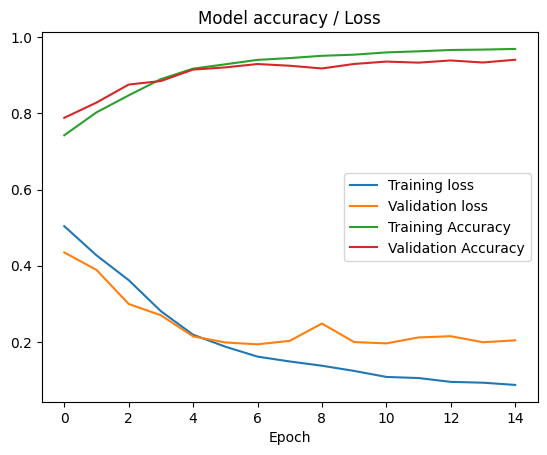

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy / Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'])
plt.show()

In [28]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,classification_report,roc_curve

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    
    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'Model')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('ROC Curve',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc

451/451 [==============================] - 6s 11ms/step


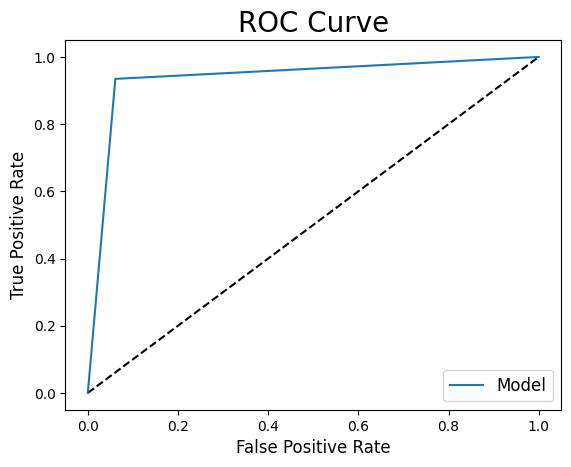

Training Accuracy: 98.92%
Testing Accuracy: 93.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      6895
           1       0.94      0.93      0.94      7532

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427

AUC score 0.9368099829896671
Total time required for testing 30.15152621269226


In [29]:
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total time required for testing",t.time()-start)

In [30]:
results = model.evaluate(x_test,y_test)
print('test loss, test acc:', results)

451/451 [==============================] - 6s 12ms/step - loss: 0.2128 - acc: 0.9367
test loss, test acc: [0.212774857878685, 0.9367159008979797]
